In [1]:
import torch
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForXVector
import commons
import utils
from models import SynthesizerTrn
from text.symbols import symbols
from text import text_to_sequence
import random
from pathlib import Path
import numpy as np
import librosa

from IPython.display import Audio
import matplotlib.pyplot as plt

In [11]:
ROOT_DIR = "../dataset/"

In [17]:
def get_text(text, hps, cleaners):
#     text_norm = text_to_sequence(text, hps.data.text_cleaners)
    text_norm = text_to_sequence(text, cleaners)
    if hps.data.add_blank:
        text_norm = commons.intersperse(text_norm, 0)
    text_norm = torch.LongTensor(text_norm)
    return text_norm

def load_data(path):
    au, sr = librosa.load(path, sr = 22050)
    embed_ref = torch.load(path.replace(".wav", ".emb.pt").replace("dataset16", "embed"), "cpu")
    return au, sr, embed_ref.unsqueeze(0)

def choose_ref(only_vivo=False, multiple=False, spkr_id=None):
    # choose a person
    if spkr_id is None:
        if only_vivo:
            spkr_id = str(random.randint(1, 46))
        else:
            spkr_id = random.choice(keys)

    # choose a path
    if multiple:
        embed_ref = []
        for i in range(10):
            path = random.choice(spkr_dict[spkr_id])
            path = ROOT_DIR + path
            au, sr, embed = load_data(path)
            embed_ref.append(embed)
        return path, (au, sr, torch.mean(torch.stack(embed_ref), dim=0))
    
    path = random.choice(spkr_dict[spkr_id])
    path = ROOT_DIR + path
    
    # load data
    return path, load_data(path)

In [4]:
with open("./filelists/vivo_filelist.txt.cleaned", "r") as f:
    data = f.readlines()
data = [line.split("|")[:2] for line in data]

In [5]:
spkr_dict = {}
for path, id in data:
    if id not in spkr_dict:
        spkr_dict[id] = [path]
    else:
        spkr_dict[id].append(path)

In [6]:
def segment_au(au, sr):
    length = sr * 2
    steps = int(len(au) / length)
    result = []
    for i in range(steps):
        result.append(au[length * i: length * (i+1)])
    if len(au) / length - float(steps) > 0.5:
        result.append(au[length * steps:])
    return result

In [7]:
keys = list(spkr_dict.keys())

In [8]:
hps = utils.get_hparams_from_file("./configs/my_base.json")
net_g = SynthesizerTrn(
    len(symbols),
    hps.data.filter_length // 2 + 1,
    hps.train.segment_size // hps.data.hop_length,
    **hps.model).cpu()
net_g.eval()

utils.load_checkpoint("/vtca/checkpoints/vits/vivo_ddp/G_102500.pth", net_g, None)

(SynthesizerTrn(
   (enc_p): TextEncoder(
     (emb): Embedding(194, 192)
     (encoder): Encoder(
       (drop): Dropout(p=0.1, inplace=False)
       (attn_layers): ModuleList(
         (0): MultiHeadAttention(
           (conv_q): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (conv_k): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (conv_v): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (conv_o): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (drop): Dropout(p=0.1, inplace=False)
         )
         (1): MultiHeadAttention(
           (conv_q): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (conv_k): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (conv_v): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (conv_o): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (drop): Dropout(p=0.1, inplace=False)
         )
         (2): MultiHeadAttention(
           (conv_q): Conv1d(192, 192, kernel_siz

In [ ]:
device = "cpu"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("../wav_feat_extractor")
model = Wav2Vec2ForXVector.from_pretrained("../wav2vec").to(device)

In [179]:
real_au, sr = librosa.load("./samples/minhanh.wav", sr=22050)
inputs = feature_extractor(
  segment_au(real_au, sr), sampling_rate=sr, return_tensors="pt", padding=True
)
with torch.no_grad():
    embed_ref = model(input_values=inputs["input_values"].to(device),
                     attention_mask=inputs["attention_mask"].to(device)).embeddings
print("Segment", len(embed_ref))
embed_ref = torch.mean(embed_ref, dim=0, keepdim=True)

Segment 3


In [69]:
# real_au, sr, embed_ref = load_data("../data/dataset16/VIVO/VIVOSSPK38_003.wav")
# real_au, sr, embed_ref = load_data("../data/dataset16/JVS/jvs001/BASIC5000_1356.wav")
# real_au, sr, embed_ref = load_data("../data/dataset16/VIVO/VIVOSSPK42_095.wav")
path, (real_au, sr, embed_ref) = choose_ref(only_vivo=False, multiple=True, spkr_id="39")
print(path)

../dataset/VIVO/VIVOSSPK39_113.wav


In [75]:
# text = "xin chào mọi người tôi tên là tố nhi"
# text = "Tôi có thể giúp gì cho bạn?"
text = "tại Quốc hội thảo luận tại hội trường về dự án Luật Khám chữa bệnh sửa đổi"
# text = "về dự án Luật Khám chữa bệnh sửa đổi cho Environment"
# text = "chào mừng mọi người đã đến với thế giới artificial intelligence"
# text = "watashi no tomodachi wa benkyoshimasu"
# text = "ông tính toán có hai đôi tàu cũng chưa đủ"
# text = "hello everyone my name is Alice."
# text = "go over the moon"
# text = "Welcome to CS Zone channel. My name is Anthony. I am an artificial intelligence enthusiast. nice to meet you"
# stn_tst = get_text(text, hps, ["english_cleaners2"])
stn_tst = get_text(text, hps, ["vietnamese_cleaner"])
with torch.no_grad():
    x_tst = stn_tst.cpu().unsqueeze(0)
    x_tst_lengths = torch.LongTensor([stn_tst.size(0)]).cpu()
    # o = net_g.infer(x_tst, x_tst_lengths, embed_ref, noise_scale=.5, noise_scale_w=0.5, length_scale=1)
    fake_au = net_g.infer(x_tst, x_tst_lengths, embed_ref, noise_scale=0.5, noise_scale_w=0.5, length_scale=1)[0][0,0].data.cpu().float().numpy()

Text(0.5, 1.0, 'Fake Audio')

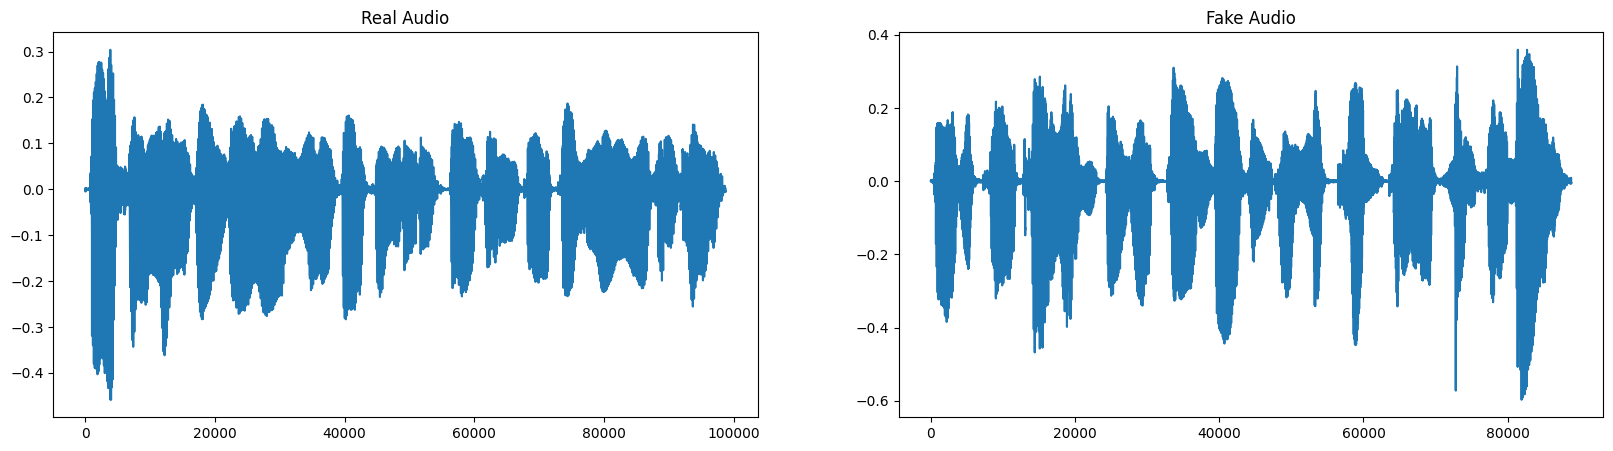

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(real_au)
ax[0].set_title("Real Audio")
ax[1].plot(fake_au)
ax[1].set_title("Fake Audio")

In [77]:
# gnerated voice
Audio(data=fake_au, rate=sr)

In [44]:
# real voice
Audio(data=real_au, rate=sr)

In [150]:
s1 = get_text("Chào mừng mọi người đã đến với ", hps, ["vietnamese_cleaner"])
s2 = get_text("VTC Academy", hps, ["english_cleaners2"])
stn_tst = torch.cat([s1, s2])

In [73]:
ref1 = embed_ref

In [47]:
ref2 = embed_ref

In [74]:
embed_ref = torch.mean(torch.stack([ref1[0], ref2[0]]), dim=0).unsqueeze(0)

In [20]:
len(real_au) / 32000

2.35684375

In [21]:
embed_ref.shape

torch.Size([1, 512])